# Image Compression Performance

Overall performance of my image display widget based on HTML `Canvas` element is very much dependent on choices made for compression and decompression.  It takes time to compress the image, transfer from back-end to front-end, then decompress and display.  I want to measure the round-trip times for this process with server and client both running on my laptop.

In [1]:
from __future__ import print_function, unicode_literals, division, absolute_import

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import imageio
import IPython

from tictoc import Timer

from widget_canvas import widget_canvas

## Helper Function

In [2]:
def time_compress(func, *args, **kwargs):
    num = 50
    time_best = np.inf
    out_best = None
    
    for k in range(num):
        with Timer(verbose=False) as timer:
            out = func(*args, **kwargs)
            
        if timer.time < time_best:
            time_best = timer.time
            out_best = out
    
    time_ms = time_best * 1.e3
    size_kb = len(out_best)/1024
    
    return time_ms, size_kb

## Load the Data

In [3]:
data_doberman = imageio.imread('images/Doberman.jpg')
data_whippet = imageio.imread('images/Whippet.jpg')

template = 'Time: {:.1f} ms,  Size: {:.1f} KB'

## PNG

In [4]:
fmt = 'png'

In [5]:
t, s = time_compress(imageio.imwrite,
                     imageio.RETURN_BYTES, data_doberman,
                     format=fmt)

print(template.format(t, s))

Time: 25.2 ms,  Size: 131.4 KB


## JPEG

http://imageio.readthedocs.org/en/latest/format_jpeg.html#jpeg

In [6]:
fmt = 'jpg'
quality = 90

In [7]:
t, s = time_compress(imageio.imwrite,
                     imageio.RETURN_BYTES, data_doberman,
                     format=fmt, quality=quality, optimize=False, baseline=False)

print(template.format(t, s))

Time: 3.2 ms,  Size: 25.0 KB


## WEBP

Support for WebP within ImageIO package is not that great. Specifically it does not expose the quality parameter when compressing an image.  PILLOW (PIL fork) on the other hand does expose this control.  Something to consider the next time I come back to this part of the project.

In [8]:
fmt = 'webp'

In [9]:
t, s = time_compress(imageio.imwrite,
                     imageio.RETURN_BYTES, data_doberman,
                     format=fmt)

print(template.format(t, s))

Time: 36.1 ms,  Size: 10.3 KB


## JPEG at Various Qualities

In [15]:
fmt = 'jpg'
qualities = [100, 99, 98, 97, 96, 95, 93, 90, 85, 80, 70, 60, 50]

In [26]:
results = []
for Q in qualities:
    ts = time_compress(imageio.imwrite,
                         imageio.RETURN_BYTES, data_doberman,
                         format=fmt, quality=Q, optimize=False, baseline=False)
    results.append(ts)
results = np.asarray(results).T

results_A = results

In [27]:
results = []
for Q in qualities:
    ts = time_compress(imageio.imwrite,
                         imageio.RETURN_BYTES, data_doberman,
                         format=fmt, quality=Q, optimize=True, baseline=False)
    results.append(ts)
results = np.asarray(results).T

results_B = results

In [28]:
results = []
for Q in qualities:
    ts = time_compress(imageio.imwrite,
                         imageio.RETURN_BYTES, data_doberman,
                         format=fmt, quality=Q, optimize=True, baseline=True)
    results.append(ts)
results = np.asarray(results).T

results_C = results

In [24]:
qualities

[100, 99, 98, 97, 96, 95, 93, 90, 85, 80, 70, 60, 50]

## Nice Plots

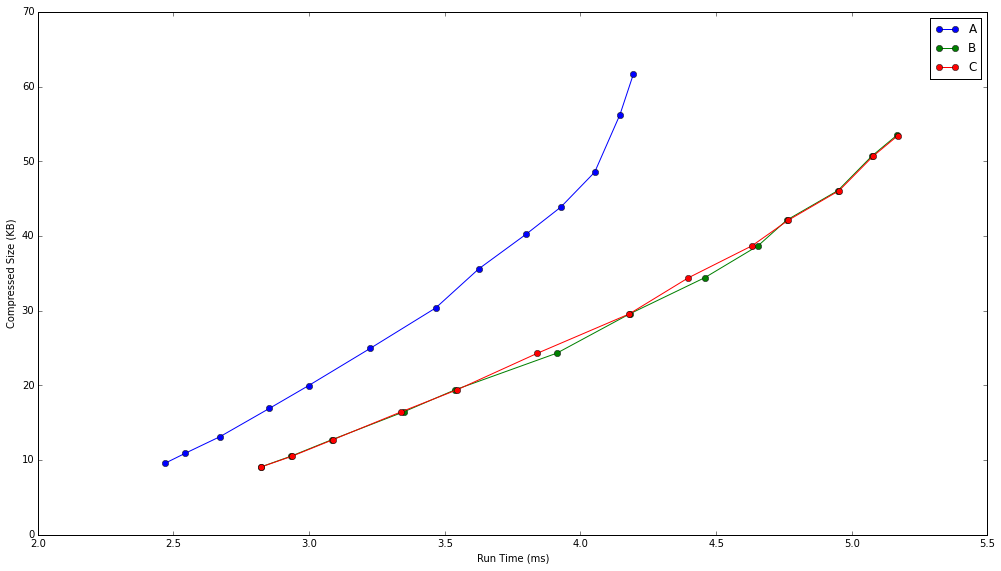

In [29]:
fig, ax = plt.subplots(figsize=(14, 8))

ts, ss = results_A
ax.plot(ts, ss, '-o', label='A')

ts, ss = results_B
ax.plot(ts, ss, '-o', label='B')

ts, ss = results_C
ax.plot(ts, ss, '-o', label='C')

ax.set_xlabel('Run Time (ms)')
ax.set_ylabel('Compressed Size (KB)')
ax.set_xlim(2., 5.5)
ax.set_ylim(0, 70)
ax.legend(loc=0)

plt.tight_layout()